# Illya-BOICHUK-Camp-2025

## Answer

I downloaded the data sets from Kaggle: https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist/notebook

### 1 Import

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2 Config variables

In [20]:
device = 'cpu'

input_size = 28 * 28
hidden_size = 512
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5

### 3 Read and prepare data

In [21]:
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

images = train_df.drop('label', axis=1).values
images = images.astype(np.float32) / 255.0
all_images = images.reshape(-1, 1, 28, 28)

mean = np.mean(all_images)
std = np.std(all_images)

print('mean:', mean)
print('std:', std)

mean: 0.13109311
std: 0.30862153


### 4 Custom Dataset

In [22]:
class CustomMNIST(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        self.has_label = 'label' in self.data.columns
        if self.has_label:
            self.labels = self.data['label'].values
            self.images = self.data.drop('label', axis=1).values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
        else:
            self.images = self.data.values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.tensor(image, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.has_label:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [23]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Normalize((mean,), (std,))
])
test_transform = transforms.Compose([
    transforms.Normalize((mean,), (std,))
])

train_dataset = CustomMNIST(train_df, transform=train_transform)
val_dataset = CustomMNIST(val_df, transform=test_transform)
test_dataset = CustomMNIST(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 5 MNIST Model 

In [24]:
class MNISTModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [25]:
model = MNISTModel(input_size, hidden_size, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### 5.1 Define function

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    running_loss = correct = total = 0
    tqdm_loader = tqdm(dataloader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch, (X, y) in enumerate(tqdm_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
        if batch % 100 == 0:
            tqdm_loader.set_postfix(loss=loss.item())
    return running_loss / len(dataloader), 100 * correct / total

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, 100 * correct

#### 5.2 Train model

In [27]:
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

print("-" * 60)
for epoch in range(num_epochs):
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, epoch)
    val_loss, val_acc = test_loop(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("-" * 60)
print("\nEpoch Progress:")
print("Epoch | Train Loss | Val Loss | Train Acc | Val Acc")
for i in range(num_epochs):
    print(f"{i+1:5d} | {train_losses[i]:10.4f} | {val_losses[i]:9.4f} | {train_accuracies[i]:9.2f} | {val_accuracies[i]:8.2f}")
print("-" * 60)

------------------------------------------------------------


Epoch 1/5: 100%|██████████| 525/525 [00:58<00:00,  8.98batch/s, loss=0.224]


Epoch [1/5], Train Loss: 0.5063, Train Acc: 83.93%, Val Loss: 0.1725, Val Acc: 94.48%


Epoch 2/5: 100%|██████████| 525/525 [00:59<00:00,  8.80batch/s, loss=0.222]


Epoch [2/5], Train Loss: 0.2346, Train Acc: 92.49%, Val Loss: 0.1075, Val Acc: 96.68%


Epoch 3/5: 100%|██████████| 525/525 [01:03<00:00,  8.23batch/s, loss=0.0813]


Epoch [3/5], Train Loss: 0.1862, Train Acc: 94.21%, Val Loss: 0.0995, Val Acc: 96.89%


Epoch 4/5: 100%|██████████| 525/525 [01:04<00:00,  8.16batch/s, loss=0.158] 


Epoch [4/5], Train Loss: 0.1610, Train Acc: 94.91%, Val Loss: 0.0817, Val Acc: 97.52%


Epoch 5/5: 100%|██████████| 525/525 [01:03<00:00,  8.27batch/s, loss=0.0751]


Epoch [5/5], Train Loss: 0.1449, Train Acc: 95.32%, Val Loss: 0.0769, Val Acc: 97.60%
------------------------------------------------------------

Epoch Progress:
Epoch | Train Loss | Val Loss | Train Acc | Val Acc
    1 |     0.5063 |    0.1725 |     83.93 |    94.48
    2 |     0.2346 |    0.1075 |     92.49 |    96.68
    3 |     0.1862 |    0.0995 |     94.21 |    96.89
    4 |     0.1610 |    0.0817 |     94.91 |    97.52
    5 |     0.1449 |    0.0769 |     95.32 |    97.60
------------------------------------------------------------


### 6 Testing visualization

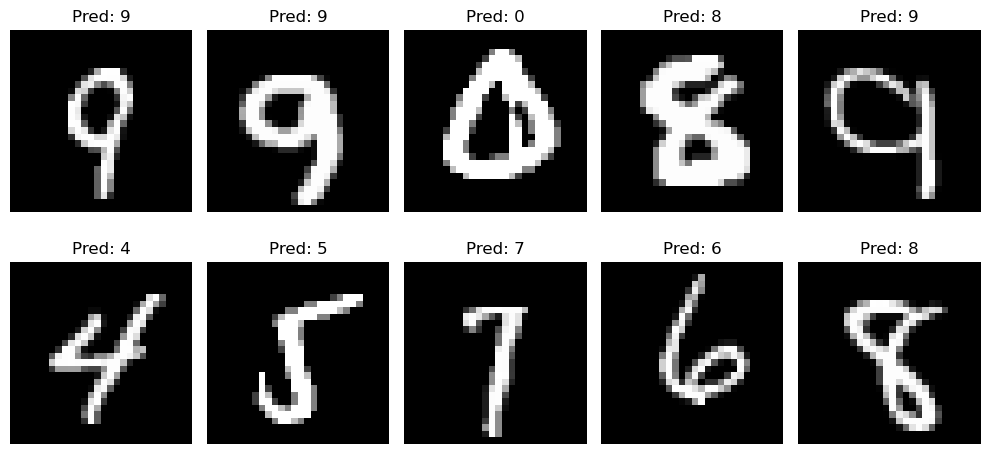

In [28]:
model.eval()
test_samples = random.sample(range(len(test_dataset)), 10)
predictions = []
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
with torch.no_grad():
    for i, idx in enumerate(test_samples):
        image = test_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        _, predicted = torch.max(output.data, 1)
        predictions.append((predicted.item()))
        image = image.squeeze().numpy() * std + mean
        ax = axes[i // 5, i % 5]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Pred: {predicted.item()}')
        ax.axis('off')
plt.tight_layout()
plt.show()

### 7 Save model

In [ ]:
torch.save(model.state_dict(), 'mnist_model.pth')